In [59]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import heapq

In [60]:
def generate_exponential_sample(alpha: float, num_of_observes: int) -> np.array:
    return np.random.exponential(alpha, num_of_observes)

def mean_times_windows_for_2(alpha: float, windows_num: int, iters_num: int = 50) -> np.array:
    # if windows_num == n, we can serve no more than 2 * n clients

    sample_matrix_of_mean_times_of_every_queue_len = [] # time for i-th queue length is in
                                                        # i-th columns (not line)
    queue_lengths = list(range(windows_num, 2 * windows_num, 5))

    for _ in range(iters_num):
        serving_times = sorted(generate_exponential_sample(alpha,  windows_num))
        wait_times = []
        mean_wait_times = []
        for ql in queue_lengths:
            wait_times.append(serving_times[ql - windows_num])
            mean_wait_times.append(np.mean(wait_times))
        sample_matrix_of_mean_times_of_every_queue_len.append(mean_wait_times)
    
    return np.mean(sample_matrix_of_mean_times_of_every_queue_len, axis=0)

def mean_times_windows_for_any(alpha: float, windows_num: int, max_queue_len: int,
                               iters_num: int = 50) -> np.array:
     sample_matrix_of_mean_times_of_every_queue_len = []
     queue_lengths = list(range(windows_num, max_queue_len, 5))

     for _ in range(iters_num):
         serving_times = list(generate_exponential_sample(alpha,  windows_num))
         heapq.heapify(serving_times)
         wait_times = []
         mean_wait_times = []
         for ql in queue_lengths:
             time_to_next_free_window = heapq.heappop(serving_times)
             wait_times.append(time_to_next_free_window)
             mean_wait_times.append(np.mean(wait_times))
             heapq.heappush(serving_times, time_to_next_free_window + np.random.exponential(alpha))
         sample_matrix_of_mean_times_of_every_queue_len.append(mean_wait_times)
     return np.mean(sample_matrix_of_mean_times_of_every_queue_len, axis=0)

In [61]:
def plots_windows_for_2(alphas: List[float] = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
                        windows_nums: List[int] = [100, 200, 400, 800, 1600, 3200]):
    for wn in windows_nums:
        for a in alphas:
            plt.plot(list(range(wn, 2 * wn, 5)), mean_times_windows_for_2(a, wn), label=f"alpha={a}")
        plt.xlabel('Queue length')
        plt.ylabel('Mean waiting time')
        plt.title(f'{wn} windows for 2 clients')
        plt.legend()
        plt.show()

def plots_windows_for_any(alphas: List[float] = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
                        windows_nums: List[int] = [100, 200, 400, 800, 1600, 3200]):
    for wn in windows_nums:
        for a in alphas:
            plt.plot(list(range(wn, 5 * wn, 5)), mean_times_windows_for_any(a, wn, 5 * wn),
                     label=f"alpha={a}")
        plt.xlabel('Queue length')
        plt.ylabel('Mean waiting time')
        plt.title(f'{wn} windows for any clients')
        plt.legend()
        plt.show()

В каждом эксперименте мы считаем среднее время, которое человеку нужно будет ждать в зависимости от длины очереди, в которой он стоит. При этом количество окон постоянно в одном эксперименте, в качестве параметра $\alpha$ берется несколько возможных значений. 

В начале каждого эксперимента сначала задается время обслуживания первых клиентов, которые обслуживаются с самого открытия. Далее для каждого следующего клиента мы считаем время ожидания -- время первого освободившегося окна (в случаи окон для двух клиентов используется сортированный список, а для других случаев -- куча). Дальше это время ожидания добавляется в выборочное среднее, которое будет являться ответом для очереди соответствующей длины (т.е. если это был $i$-ый клиент, то ответ для очереди длины $i$). 

Чтобы убрать возможные шумы, эти действия повторяются `iters_num` количество раз.

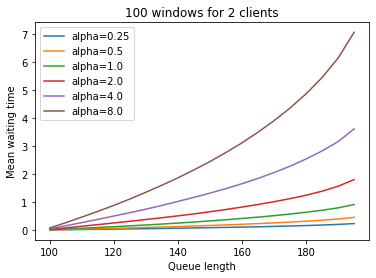

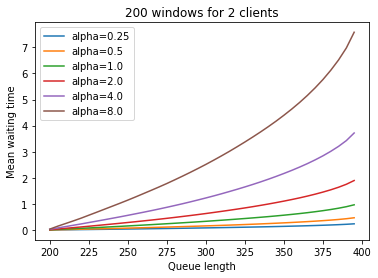

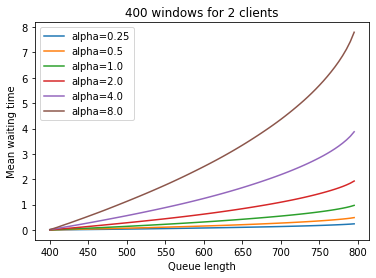

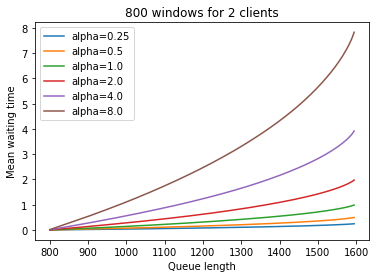

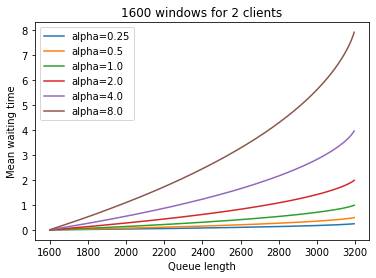

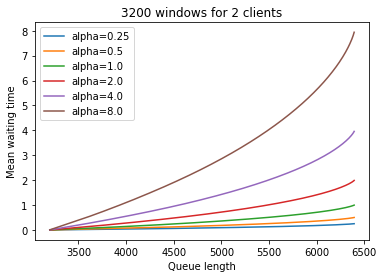

In [62]:
plots_windows_for_2()

Получаем нелинейную зависимость времени ожидания от длины очереди. Похоже на степенную или полиномиальную зависимость. Также, чем больше был параметр, тем дольше клиентам приходилось стоять в очереди -- вполне логично. И, что и так было предсказуемо, чем длиннее очередь, тем дольше клиенты в среднем в очереди стоят.

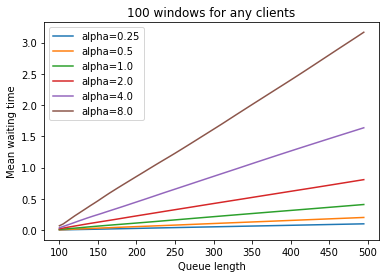

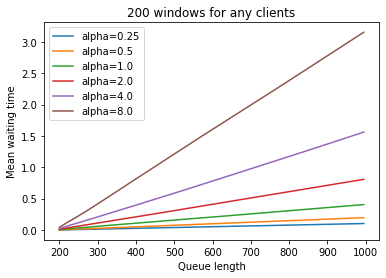

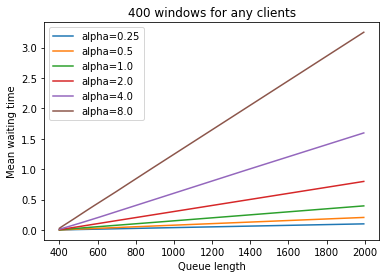

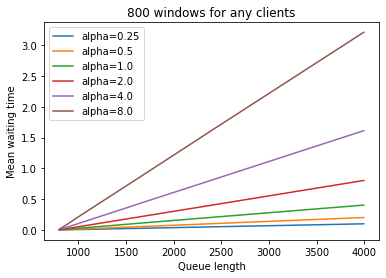

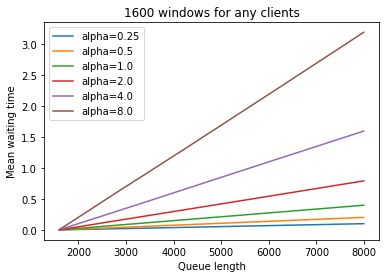

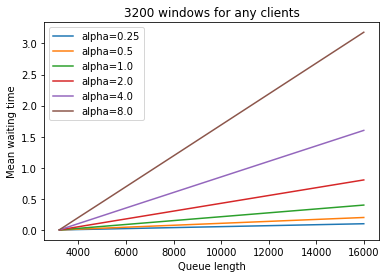

In [63]:
plots_windows_for_any()

Получаем линейную зависимость времени ожидания от длины очереди.

Мы поняли, что если количество клиентов, которых может обслужить одно окно, ограниченно, рост времени ожидания будет сильно быстрее линейного. Поэтому управляющему банком рекомендуется снять это ограничение, если оно есть.